In [2]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here

data = pd.read_csv(here("data/recent_donations.csv"))
data

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


## Linear Regression

In [ ]:
def linear_basis(x):
    return x^2

def linear_regression(x,y,basis_function):
    N = len(y)
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N, 1)), train_features))
    A = np.linalg.inv(PHI.T@PHI)
    D = A@PHI.T
    w = D@y
    return np.dot(PHI, w), w
    

def predict_linear_regression(x,N,w,basis_function):
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N, 1)), train_features))
    return np.dot(PHI, w)

10.0


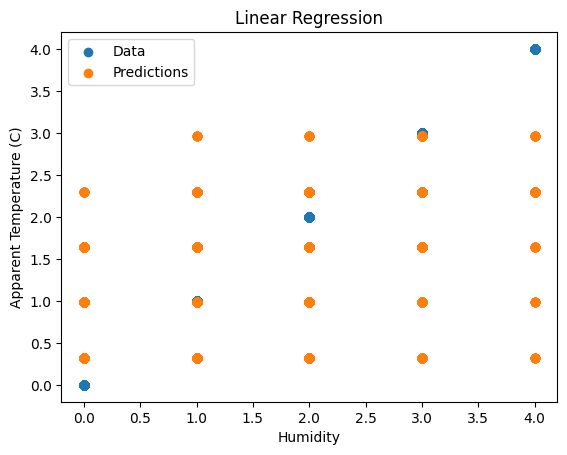

MSE:
1.5685231399067447
Log Likelihood:
-698758.0976894234


In [11]:
#in this case x and y are row vectors, so we need to convert them to column vectors
x = data["y_2017"].to_numpy().reshape(-1,1)
y = data["y_2018"].to_numpy().reshape(-1,1)

beta = 0.01
print(np.sqrt(1/beta))

y_pred_linear, w = linear_regression(x,y,linear_basis)

plt.scatter(data["y_2017"], data["y_2017"], label = 'Data')
plt.scatter(data["y_2018"].to_numpy(), y_pred_linear, label = 'Predictions')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_pred_linear.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred_linear.T-y)**2))

## Generalized Linear Models

Let's define an overdispersed poisson

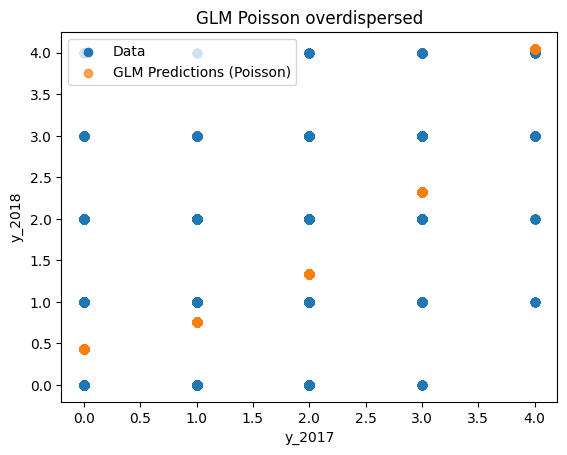

MSE (GLM Poisson):
0.6968788158739364
Log Likelihood (Poisson overdisperso):
-8595.367816297525


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Base function
def linear_basis(x):
    return x

# PHI
def design_matrix(x, basis_function):
    N = x.shape[0]
    features = basis_function(x)
    return np.hstack((np.ones((N, 1)), features))

# Link function e inversa
def link_function(mu):  # log link
    return np.log(mu)

def inverse_link_function(eta):  # exp
    return np.exp(eta)

# Log-likelihood Poisson overdisperso (negativa per il minimo)
def neg_log_likelihood(w, X, y, phi):
    eta = X @ w
    mu = inverse_link_function(eta)
    return np.sum((y - mu)**2) / (2 * phi) + np.sum(mu) - np.sum(y * eta)

# Fit GLM con Poisson overdisperso
def fit_glm_poisson(x, y, basis_function, phi=1.0):
    X = design_matrix(x, basis_function)
    init_w = np.zeros((X.shape[1],))
    result = minimize(neg_log_likelihood, init_w, args=(X, y.ravel(), phi), method='BFGS')
    return result.x  # pesi w

# Predict
def predict_glm(x, w, basis_function):
    X = design_matrix(x, basis_function)
    eta = X @ w
    return inverse_link_function(eta)

# ===========================
# INPUT DATA
# ===========================

x = data["y_2017"].to_numpy().reshape(-1,1)
y = data["y_2018"].to_numpy().reshape(-1,1)

# Fit modello
phi_overdisp = 2.0  # esempio: overdispersion φ = 2
w_glm = fit_glm_poisson(x, y, linear_basis, phi=phi_overdisp)

# Prediction
y_pred_glm = predict_glm(x, w_glm, linear_basis).reshape(-1, 1)

# ===========================
# PLOT
# ===========================

plt.scatter(x, y, label='Data')
plt.scatter(x, y_pred_glm, label='GLM Predictions (Poisson)', alpha=0.7)
plt.xlabel("y_2017")
plt.ylabel("y_2018")
plt.title("GLM Poisson overdispersed")
plt.legend()
plt.show()

# ===========================
# VALUTAZIONE
# ===========================

print("MSE (GLM Poisson):")
print(np.mean((y_pred_glm - y)**2))

log_mu = np.log(y_pred_glm + 1e-9)  # stabilità numerica
log_likelihood = -np.sum((y - y_pred_glm)**2) / (2 * phi_overdisp) - np.sum(y_pred_glm) + np.sum(y * log_mu)

print("Log Likelihood (Poisson overdisperso):")
print(log_likelihood)


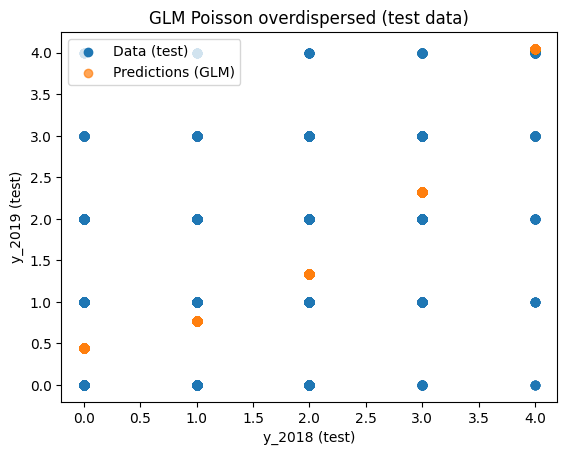

MSE (test):
0.7560008483064289
Log Likelihood (test, Poisson overdispersed):
-7383.918542993323


In [13]:
# --- Test set
x_test = data["y_2018"].to_numpy().reshape(-1,1)
y_test = data["y_2019"].to_numpy().reshape(-1,1)

# --- Predizioni con il modello GLM
y_test_pred = predict_glm(x_test, w_glm, linear_basis).reshape(-1, 1)

# --- Plot
plt.scatter(x_test, y_test, label='Data (test)')
plt.scatter(x_test, y_test_pred, label='Predictions (GLM)', alpha=0.7)
plt.xlabel("y_2018 (test)")
plt.ylabel("y_2019 (test)")
plt.title("GLM Poisson overdispersed (test data)")
plt.legend()
plt.show()
# --- MSE
print("MSE (test):")
print(np.mean((y_test_pred - y_test)**2))

# --- Log-verosimiglianza (test)
log_mu_test = np.log(y_test_pred + 1e-9)  # stabilità numerica
log_likelihood_test = -np.sum((y_test - y_test_pred)**2) / (2 * phi_est) - np.sum(y_test_pred) + np.sum(y_test * log_mu_test)

print("Log Likelihood (test, Poisson overdispersed):")
print(log_likelihood_test)


## Bayesian Regression

### Gaussian

In [29]:
#Bayesian Regression with alpha and beta fixed and a gaussian prior

def bayesian_linear_regression(x,y,basis_function, alpha, beta):
    N = len(y)
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N,1)), train_features))
    SN = np.linalg.inv(alpha*np.eye(PHI.shape[1]) + beta*PHI.T@PHI)
    mN = beta*SN@PHI.T@y
    return np.dot(mN.T, PHI.T), np.sqrt(1/beta+np.diag(PHI@SN@PHI.T)), mN, SN

def predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta):
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N,1)), train_features))
    return np.dot(mN.T, PHI.T)[0], np.sqrt(1/beta+np.diag(PHI@SN@PHI.T))

def plot_bayesian_LR(mN, SN, N, x, basis_function, beta):
    mean, sigma = predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta)
    plt.plot(x.T[0],mean)
    plt.fill_between(x.T[0], mean-sigma, mean+sigma, alpha=0.2)


MSE (training set):
1.568511216520435
Log Likelihood (training set):
-698554.7713178517
MSE (test set):
1.6075204174342757
Log Likelihood (test set):
-715186.2745745645


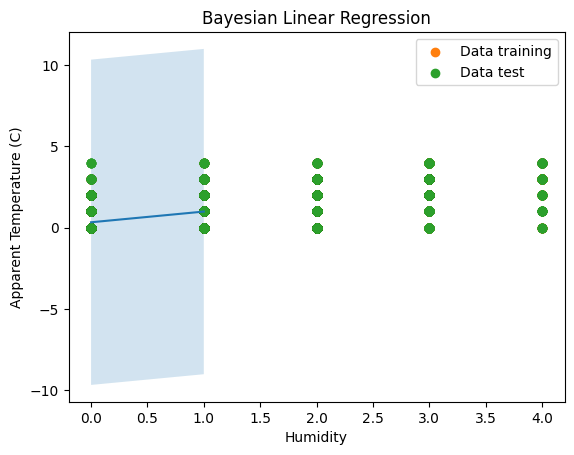

In [31]:
alpha = 0.002

y_pred_bayes, sigma_pred, mN, SN = bayesian_linear_regression(x,y,linear_basis, alpha, beta)

print("MSE (training set):")
print(np.mean((y_pred_bayes-y)**2))
print("Log Likelihood (training set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma_pred**2)) - 1/2*np.sum(((y_pred_bayes-y)**2)/(sigma_pred**2)))

mean, sigma = predict_bayesian_linear_regression(mN, SN, len(x_test), x_test, linear_basis, beta)
print("MSE (test set):")
print(np.mean((mean-y_test)**2))
print("Log Likelihood (test set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma**2)) - 1/2*np.sum(((mean-y_test)**2)/(sigma**2)))

#FOR 1D features, we can plot the regression
xrange=np.linspace(0, 1, 100).reshape(-1,1)
plot_bayesian_LR(mN, SN, len(xrange), xrange, linear_basis, beta)

plt.scatter(data["y_2018"], data["y_2017"], label='Data training')
plt.scatter(data["y_2019"], data["y_2018"], label='Data test')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Bayesian Linear Regression")
plt.legend()
plt.show()

### Poisson

$$log(μ)=ϕ^Tx ⇒μ=exp(ϕ^Tx)$$

In [14]:
def bayesian_poisson_regression(x, y, basis_function, alpha, phi_est):
    N = len(y)
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N, 1)), train_features))

    # Approssimazione Gaussiana (Fisher Information come matrice di precisione)
    mu_hat = np.exp(PHI @ np.zeros((PHI.shape[1], 1)))  # inizialmente w=0
    W = np.diag((mu_hat.flatten() / phi_est))  # Varianza Poisson ≈ mu * phi

    # Posterior (Laplace approx)
    SN_inv = alpha * np.eye(PHI.shape[1]) + PHI.T @ W @ PHI
    SN = np.linalg.inv(SN_inv)

    # MAP estimate (Newton step, semplificata)
    z = PHI @ np.zeros((PHI.shape[1], 1)) + np.linalg.pinv(W) @ (y - mu_hat)
    mN = SN @ PHI.T @ W @ z

    # Predictive mean
    log_mu_pred = PHI @ mN
    mu_pred = np.exp(log_mu_pred)

    return mu_pred, mN, SN


In [25]:
def predict_bayesian_poisson_regression(mN, SN, x, basis_function):
    N = x.shape[0]
    PHI = np.hstack((np.ones((N, 1)), basis_function(x)))
    
    log_mu_pred = (PHI @ mN).flatten()
    
    var_log_mu_pred = np.sum(PHI @ SN * PHI, axis=1)  # più robusto di einsum
    std_log_mu_pred = np.sqrt(var_log_mu_pred)
    
    mu_pred = np.exp(log_mu_pred).flatten()
    std_pred = (mu_pred * std_log_mu_pred).flatten()
    
    return mu_pred, std_pred


In [33]:
def plot_bayesian_poisson(mN, SN, x, basis_function, phi_est):
    mean, std = predict_bayesian_poisson(mN, SN, x, basis_function, phi_est)
    plt.plot(x.flatten(), mean, label="Mean prediction")
    plt.fill_between(x.flatten(), mean - std, mean + std, alpha=0.3, label="Credible interval")
    plt.title("Bayesian Poisson Regression (overdispersed)")
    plt.legend()


ValueError: 'y1' is not 1-dimensional

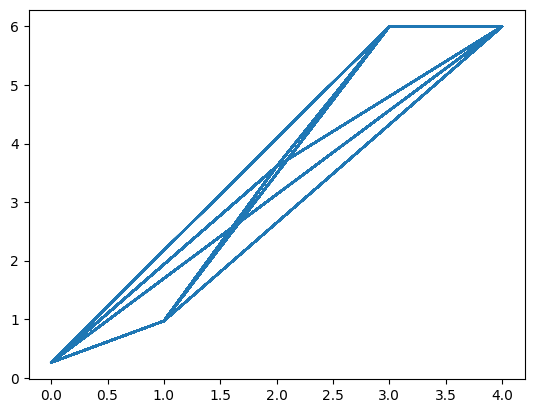

: 

In [ ]:
# Stima (train set)
mu_pred_train, mN, SN = bayesian_poisson_regression(x, y, linear_basis, alpha=1.0, phi_est=2.0)

# Plot
plot_bayesian_poisson(mN, SN, x, linear_basis, 2.0)


In [ ]:
test

In [ ]:
test

ValueError: 'y1' is not 1-dimensional

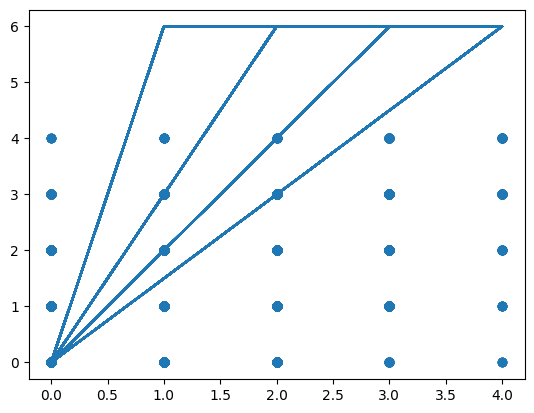

In [ ]:

# Test set
mu_pred_test, std_test = predict_bayesian_poisson(mN, SN, x_test, linear_basis, 2.0)

# Plot test
plt.figure()
plt.scatter(x_test, y_test, label="Test data")
plt.plot(x_test.flatten(), mu_pred_test, label="Predictions (test)")
plt.fill_between(x_test.flatten(), mu_pred_test - std_test, mu_pred_test + std_test, alpha=0.3)
plt.legend()
plt.title("Bayesian Poisson Regression on Test Set")


In [18]:
np.max(data["y_2018"])

np.int64(4)